## A comparison between Pytorch ,TVM and Auto-TVM for timing in classification of a small model like resnet-18

In [5]:

import mymodel
import myautotune
import myimages
import myplot
import mypytorch
import mytime
import mytvm
import mysetget

## Fetch the model
The model we are using is basic but functional. Also we are not here for training classification models so we will use the pretrained resnet-18.

In [6]:
batch_size = 100
mysetget.set_batch_size(batch_size)

## Load test images
Lets begin by creating some functions that will convert the image to the correct size for resnet-18

## Prepare the classes
Functions that print the results of the classes

## Ρun pytorch

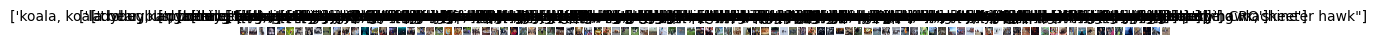

In [7]:
mypytorch.initialize_model_and_batch_size()
myimages.load_random_images(mysetget.get_batch_size())
imgs, labels = mypytorch.process_pytorch(mysetget.get_model(), mysetget.get_batch_size())
myimages.display_images_with_labels(imgs, labels, "pytorch")


In [8]:
pytorch_time = mytime.timit(mypytorch.run_pytorch, imgs)

Timing Summary:
{'mean': 15.243784798216074, 'median': 15.235776484943926, 'std': 0.02081792992484112}


## TVM without autotuning




In [ ]:
tvm_lib = None
tvm_inp_name = None
target = tvm.target.Target("cuda")
dev = tvm.cuda(0)

In [13]:
def run_module(mod):
    mod.run()
    return mod

def create_module(lib,imgs,input_name):
    dtype = "float32"
    module = graph_executor.GraphModule(lib["default"](dev))
    images=np.array(imgs).reshape((batch_size,3,224,224))
    module.set_input(input_name, tvm.nd.array(images.astype(dtype)))
    mod=run_module(module)
    output = mod.get_output(0).asnumpy()
    prediction= np.argmax(output,axis=1) 
    classes= prediction_to_class(prediction)
    return classes, module

In [14]:
def run_tvm(imgs):
    global tvm_lib, tvm_inp_name
    
    if tvm_lib is None or tvm_inp_name is None:
        print("Loading relay for TVM module.")
        lib, inp_name = tvm_relay(batch_size)
        tvm_lib = lib  # Store the TVM module globally
        tvm_inp_name = inp_name  # Store the input name globally
    
    classes ,module = create_module(tvm_lib, imgs, tvm_inp_name) 
    return imgs, classes, module

/home1/public/misampson/miniconda3/envs/tvm/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home1/public/misampson/miniconda3/envs/tvm/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading relay for TVM module.


One or more operators have not been tuned. Please tune your model for better performance. Use DEBUG logging level to see more details.


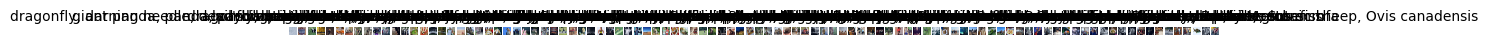

In [15]:
def load_model_and_batch_size(batch_size):
    batch_size=batch_size
    model_name = "resnet18"
    model = getattr(models, model_name)(pretrained="imagenet")
    model = model.eval()
    return model,batch_size
model, batch_size = load_model_and_batch_size(batch_size)
imgs,classes, module=run_tvm(get_images())
display_images_with_labels(imgs, classes, "tvm")

In [16]:
tvm_wo_autotune_time=timit(run_module,module)

Timing Summary:
{'mean': 2.3323784270789476, 'median': 2.6370160221122205, 'std': 0.478496602849889}


## Begin TVM steps




In [17]:
import tvm.relay.testing
from tvm.autotvm.tuner import XGBTuner, GATuner, RandomTuner, GridSearchTuner
import tvm.contrib.graph_executor as runtime
import tvm.auto_scheduler as auto_scheduler
from tvm.autotvm.tuner import XGBTuner

## Define Network
First we need to define the network in relay frontend API.
We can load some pre-defined network from :code:`tvm.relay.testing`.
We can also load models from MXNet, ONNX and TensorFlow.



In [18]:
def get_network(name, batch_size):
    """Get the symbol definition and random weight of a network"""
    input_shape = (batch_size, 3, 224, 224)
    output_shape = (batch_size, 1000)

    if "resnet" in name:
        n_layer = int(name.split("-")[1])
        mod, params = relay.testing.resnet.get_workload(
            num_layers=n_layer, batch_size=batch_size, dtype=dtype
        )
    elif "vgg" in name:
        n_layer = int(name.split("-")[1])
        mod, params = relay.testing.vgg.get_workload(
            num_layers=n_layer, batch_size=batch_size, dtype=dtype
        )
    elif name == "mobilenet":
        mod, params = relay.testing.mobilenet.get_workload(batch_size=batch_size, dtype=dtype)
    elif name == "squeezenet_v1.1":
        mod, params = relay.testing.squeezenet.get_workload(
            batch_size=batch_size, version="1.1", dtype=dtype
        )
    elif name == "inception_v3":
        input_shape = (batch_size, 3, 299, 299)
        mod, params = relay.testing.inception_v3.get_workload(batch_size=batch_size, dtype=dtype)
    elif name == "mxnet":
        # an example for mxnet model
        from mxnet.gluon.model_zoo.vision import get_model

        block = get_model("resnet18_v1", pretrained=True)
        mod, params = relay.frontend.from_mxnet(block, shape={"data": input_shape}, dtype=dtype)
        net = mod["main"]
        net = relay.Function(
            net.params, relay.nn.softmax(net.body), None, net.type_params, net.attrs
        )
        mod = tvm.IRModule.from_expr(net)
    else:
        raise ValueError("Unsupported network: " + name)

    return mod, params, input_shape, output_shape

## Set Tuning Options
Before tuning, we apply some configurations.



In [19]:
#### DEVICE CONFIG ####
target = tvm.target.cuda()

#### TUNING OPTION ####
network = "resnet-18"
log_file = "%s.log" % network
dtype = "float32"

tuning_option = {
    "log_filename": log_file,
    "tuner": "xgb",
    "n_trial": 2000,
    "early_stopping": 20,
    "measure_option": autotvm.measure_option(
        builder=autotvm.LocalBuilder(timeout=10),
        runner=autotvm.LocalRunner(number=20, repeat=3, timeout=4, min_repeat_ms=150),
    ),
}

/home1/public/misampson/miniconda3/envs/tvm/lib/python3.11/site-packages/tvm-0.17.dev2+ga64d1f1cc-py3.11-linux-x86_64.egg/tvm/target/target.py:446: UserWarning: Try specifying cuda arch by adding 'arch=sm_xx' to your target.
  warnings.warn("Try specifying cuda arch by adding 'arch=sm_xx' to your target.")


## Begin Tuning
Now we can extract tuning tasks from the network and begin tuning.
Here, we provide a simple utility function to tune a list of tasks.
This function is just an initial implementation which tunes them in sequential order.
We will introduce a more sophisticated tuning scheduler in the future.



In [20]:
# You can skip the implementation of this function for this tutorial.
def tune_tasks(
    tasks,
    measure_option,
    tuner="xgb",
    n_trial=1000,
    early_stopping=20,
    log_filename="tuning.log",
    use_transfer_learning=True,
):
    # create tmp log file
    tmp_log_file = log_filename + ".tmp"
    if os.path.exists(tmp_log_file):
        os.remove(tmp_log_file)

    for i, tsk in enumerate(reversed(tasks)):
        prefix = "[Task %2d/%2d] " % (i + 1, len(tasks))

        # create tuner
        if tuner == "xgb":
            tuner_obj = XGBTuner(tsk, loss_type="reg")
        elif tuner == "xgb_knob":
            tuner_obj = XGBTuner(tsk, loss_type="reg", feature_type="knob")
        elif tuner == "xgb_itervar":
            tuner_obj = XGBTuner(tsk, loss_type="reg", feature_type="itervar")
        elif tuner == "xgb_curve":
            tuner_obj = XGBTuner(tsk, loss_type="reg", feature_type="curve")
        elif tuner == "xgb_rank":
            tuner_obj = XGBTuner(tsk, loss_type="rank")
        elif tuner == "xgb_rank_knob":
            tuner_obj = XGBTuner(tsk, loss_type="rank", feature_type="knob")
        elif tuner == "xgb_rank_itervar":
            tuner_obj = XGBTuner(tsk, loss_type="rank", feature_type="itervar")
        elif tuner == "xgb_rank_curve":
            tuner_obj = XGBTuner(tsk, loss_type="rank", feature_type="curve")
        elif tuner == "xgb_rank_binary":
            tuner_obj = XGBTuner(tsk, loss_type="rank-binary")
        elif tuner == "xgb_rank_binary_knob":
            tuner_obj = XGBTuner(tsk, loss_type="rank-binary", feature_type="knob")
        elif tuner == "xgb_rank_binary_itervar":
            tuner_obj = XGBTuner(tsk, loss_type="rank-binary", feature_type="itervar")
        elif tuner == "xgb_rank_binary_curve":
            tuner_obj = XGBTuner(tsk, loss_type="rank-binary", feature_type="curve")
        elif tuner == "ga":
            tuner_obj = GATuner(tsk, pop_size=100)
        elif tuner == "random":
            tuner_obj = RandomTuner(tsk)
        elif tuner == "gridsearch":
            tuner_obj = GridSearchTuner(tsk)
        else:
            raise ValueError("Invalid tuner: " + tuner)

        if use_transfer_learning:
            if os.path.isfile(tmp_log_file):
                tuner_obj.load_history(autotvm.record.load_from_file(tmp_log_file))

        # do tuning
        tsk_trial = min(n_trial, len(tsk.config_space))
        tuner_obj.tune(
            n_trial=tsk_trial,
            early_stopping=early_stopping,
            measure_option=measure_option,
            callbacks=[
                autotvm.callback.progress_bar(tsk_trial, prefix=prefix),
                autotvm.callback.log_to_file(tmp_log_file),
            ],
        )

    # pick best records to a cache file
    autotvm.record.pick_best(tmp_log_file, log_filename)
    os.remove(tmp_log_file)

In [21]:
def tune_and_evaluate(tuning_opt,batch_size):
    # extract workloads from relay program
    print("Extract tasks...")
    mod, params, input_shape, out_shape = get_network(network, batch_size)
    tasks = autotvm.task.extract_from_program(
        mod["main"], target=target, params=params, ops=(relay.op.get("nn.conv2d"),)
    )

    # run tuning tasks
    print("Tuning...")
    tune_tasks(tasks, **tuning_opt)

    # compile kernels with history best records
    with autotvm.apply_history_best(log_file):
        print("Compile...")
        with tvm.transform.PassContext(opt_level=3):
            lib = relay.build_module.build(mod, target=target, params=params)

        # load parameters
        dev = tvm.device(str(target), 0)
        module = runtime.GraphModule(lib["default"](dev))
        data_tvm = tvm.nd.array((np.random.uniform(size=input_shape)).astype(dtype))
        module.set_input("data", data_tvm)

        # evaluate
        print("Evaluate inference time cost...")
        print(module.benchmark(dev, number=1, repeat=600))
        
    return module
# We do not run the tuning in our webpage server since it takes too long.
# Uncomment the following line to run it by yourself.
#module =tune_and_evaluate(tuning_option,batch_size)


In [22]:
def tvm_relay_with_file(logfile, network ,batch_size):
    mod, params, input_shape, out_shape = get_network(network, batch_size)
    
    with autotvm.apply_history_best(logfile):
        with tvm.transform.PassContext(opt_level=3):
            lib = relay.build(mod, target=target, params=params)
    
    # Load the compiled module onto the device
    dev = tvm.device(str(target), 0)
    module = runtime.GraphModule(lib["default"](dev))
    return module

tuning_logs_dir = "/home1/public/misampson/resnet-50/git/ITE-Forth-CARV/tuning-logs"
logfile_path = os.path.join(tuning_logs_dir, "ga-tune", "resnet-18.log")
module = tvm_relay_with_file(logfile_path, network, batch_size)


In [23]:
tvm_autotune_time=timit(run_module,module)

Timing Summary:
{'mean': 0.9457037977408618, 'median': 0.9972392981871963, 'std': 0.2880557635069541}


In [24]:
def plot_timestamps(time1, time2, time3):
    # Parse the timestamps to extract mean, median, and standard deviation values
    def parse_timestamp(timestamp):
        if timestamp is None:
            return None, None, None
        return timestamp["mean"], timestamp["median"], timestamp["std"]

    t1_mean, t1_median, t1_std = parse_timestamp(time1)
    t2_mean, t2_median, t2_std = parse_timestamp(time2)
    t3_mean, t3_median, t3_std = parse_timestamp(time3)

    # Plotting
    labels = ['Mean', 'Median', 'Std']
    t1_values = [t1_mean, t1_median, t1_std]
    t2_values = [t2_mean, t2_median, t2_std]
    t3_values = [t3_mean, t3_median, t3_std]

    x = range(len(labels))
    width = 0.2

    fig, ax = plt.subplots()
    bars = []
    
    if t1_mean is not None:
        bars.append(ax.bar(x, t1_values, width, label='Pytorch'))
    if t2_mean is not None:
        bars.append(ax.bar([i + width for i in x], t2_values, width, label='TVM without tuning'))
    if t3_mean is not None:
        bars.append(ax.bar([i + width*2 for i in x], t3_values, width, label='TVM autotune'))

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Time')
    ax.set_title('Classification Timing Comparison')
    ax.set_xticks([i + width for i in x])
    ax.set_xticklabels(labels)
    
    # Add legend only if there are bars plotted
    if bars:
        ax.legend()

    plt.show()

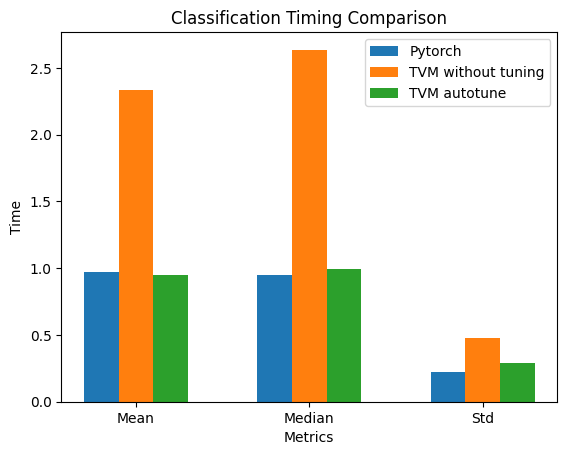

In [25]:
plot_timestamps(pytorch_time, tvm_wo_autotune_time, tvm_autotune_time)

In [26]:

def mean_timestamps(time1, time2, time3):
    # Parse the timestamps to extract mean values
    def parse_timestamp(timestamp):
        if timestamp is None:
            return None
        return timestamp["mean"]

    t1_mean = parse_timestamp(time1)
    t2_mean = parse_timestamp(time2)
    t3_mean = parse_timestamp(time3)

    # Plotting
    labels = ['Pytorch', 'TVM without tuning', 'TVM autotune']
    means = [t1_mean, t2_mean, t3_mean]

    x = range(len(labels))
    width = 0.5

    fig, ax = plt.subplots()
    bars = []

    if t1_mean is not None:
        bars.append(ax.bar(x[0], t1_mean, width, label='Pytorch'))
    if t2_mean is not None:
        bars.append(ax.bar(x[1], t2_mean, width, label='TVM without tuning'))
    if t3_mean is not None:
        bars.append(ax.bar(x[2], t3_mean, width, label='TVM autotune'))

    ax.set_xlabel('Frameworks')
    ax.set_ylabel('Mean Time')
    ax.set_title('Mean Classification Time Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Add the mean value on top of each bar
    for bar in bars:
        for b in bar:
            height = b.get_height()
            ax.annotate(f'{height:.4f}',
                        xy=(b.get_x() + b.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    plt.show()

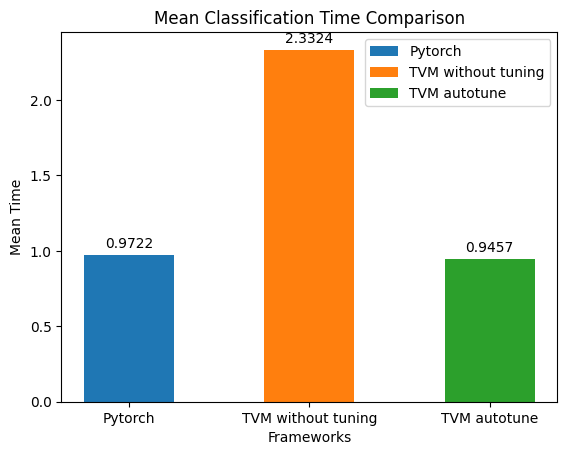

In [27]:
mean_timestamps(pytorch_time, tvm_wo_autotune_time, tvm_autotune_time)